In [1]:
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
import numpy as np
from hmmlearn import hmm
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm
import seaborn as sns


In [2]:
# def  model_function(train_data -> np.array, num_of_predictions -> int):

# 	Return prediction 

In [3]:
googl = yf.download("GOOGL", start="2018-01-01", end="2021-12-31").reset_index()
googl.Date = pd.to_datetime(googl.Date)

[*********************100%***********************]  1 of 1 completed


In [4]:
googl

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,1053.020020,1075.979980,1053.020020,1073.209961,1073.209961,1588300
1,2018-01-03,1073.930054,1096.099976,1073.430054,1091.520020,1091.520020,1565900
2,2018-01-04,1097.089966,1104.079956,1094.260010,1095.760010,1095.760010,1302600
3,2018-01-05,1103.449951,1113.579956,1101.800049,1110.290039,1110.290039,1512500
4,2018-01-08,1111.000000,1119.160034,1110.000000,1114.209961,1114.209961,1232200
...,...,...,...,...,...,...,...
993,2021-12-10,2974.000000,2979.550049,2934.080078,2960.030029,2960.030029,1222900
994,2021-12-13,2955.629883,2959.399902,2910.350098,2916.530029,2916.530029,1353500
995,2021-12-14,2879.360107,2889.600098,2824.300049,2878.139893,2878.139893,1922300
996,2021-12-15,2868.179932,2934.419922,2833.560059,2928.820068,2928.820068,1818500


In [5]:
daily_return = googl['Return'] = np.log(googl.Close /googl.Close.shift(-1)).dropna()
#(np.log(googl.Close /googl.Close.shift(-1))).dropna()
# np.log(googl.Close.pct_change()).dropna()

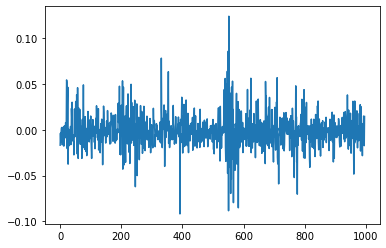

In [6]:
plt.plot(daily_return)

In [7]:
googl[googl.Date>='2021-01-01']

,Date,Open,High,Low,Close,Adj Close,Volume,Return
756,2021-01-04,1760.000000,1762.489990,1707.140015,1726.130005,1726.130005,1866200,-0.008032
757,2021-01-05,1725.089966,1746.829956,1716.900024,1740.050049,1740.050049,1018000,0.009917
758,2021-01-06,1700.260010,1743.969971,1696.099976,1722.880005,1722.880005,2329400,-0.029431
759,2021-01-07,1726.760010,1777.819946,1726.760010,1774.339966,1774.339966,2096800,-0.013152
760,2021-01-08,1777.160034,1799.359985,1761.219971,1797.829956,1797.829956,1774200,0.023377
...,...,...,...,...,...,...,...,...
993,2021-12-10,2974.000000,2979.550049,2934.080078,2960.030029,2960.030029,1222900,0.014805
994,2021-12-13,2955.629883,2959.399902,2910.350098,2916.530029,2916.530029,1353500,0.013250
995,2021-12-14,2879.360107,2889.600098,2824.300049,2878.139893,2878.139893,1922300,-0.017455
996,2021-12-15,2868.179932,2934.419922,2833.560059,2928.820068,2928.820068,1818500,0.014368


In [8]:
train,test = googl[googl.Date<'2021-01-01'].Return,googl[googl.Date>='2021-01-01'].Return
# train,test = daily_return[:2800],daily_return[-238:]

In [9]:
train_np = np.array(train).reshape(-1,1)
test_np = np.array(test[:-1]).reshape(-1,1)

# HMM 

In [10]:
def hmm_prediction_MCMC(train_data,num_of_predictions,num_samples = 100):
    
    hmm_prediction_values_list = []
    hmm_prediction_states_list = []
    all_df = pd.DataFrame()
    #print(train_data)
    for i in range(num_samples):
        #print(i)
        
        hmm_model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
        hmm_model.fit(train_data)

        predict_state = hmm_model.predict(train_data)

        hmm_prediction = hmm_model.sample(num_of_predictions,random_state = predict_state[-1])
        hmm_prediction_values = hmm_prediction[0]
        hmm_prediction_states = hmm_prediction[1]
        
        hmm_prediction_values_list.append(hmm_prediction_values) 
        hmm_prediction_states_list.append(hmm_prediction_states)
        
        temp_df = pd.DataFrame([np.repeat(i,num_of_predictions),np.arange(num_of_predictions),hmm_prediction_values.squeeze()]).T
        
        all_df = pd.concat([all_df, temp_df])
        
    return hmm_prediction_values_list,hmm_prediction_states_list,all_df

In [11]:
value_list, states_list,mcmc_df = hmm_prediction_MCMC(train_np,len(test_np))

In [12]:
mcmc_df.columns = ['repeat','time','value']
mcmc_df

,repeat,time,value
0,0.0,0.0,-0.001417
1,0.0,1.0,-0.007563
2,0.0,2.0,-0.015746
3,0.0,3.0,-0.009897
4,0.0,4.0,0.007461
...,...,...,...
236,99.0,236.0,-0.015550
237,99.0,237.0,-0.003296
238,99.0,238.0,0.012345
239,99.0,239.0,0.007235


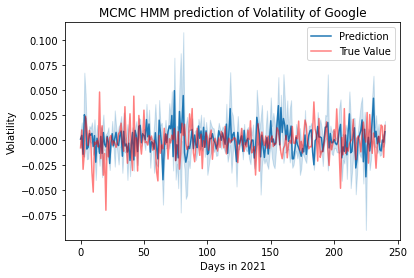

In [21]:
sns.lineplot(data=mcmc_df,x = 'time',y = 'value',ci = 'sd',label= 'Prediction' )
plt.plot(test_np,color = 'r',alpha=0.5,label = 'True Value')

plt.ylabel('Volatility')
plt.xlabel('Days in 2021')
plt.title('MCMC HMM prediction of Volatility of Google')

plt.legend()
plt.show()

In [14]:
np_all = np.array(value_list).squeeze()

In [15]:
mean_np_all = np_all.mean(axis = 0)
std_np_all = np_all.std(axis = 0)

In [16]:
mean_np_all

array([ 8.06030986e-04,  4.49245174e-03, -1.44054213e-02,  2.51115656e-02,
        2.14056734e-02, -9.19382675e-03, -7.36587870e-03,  6.12713390e-03,
        4.63756820e-03,  6.42953849e-03, -6.61333109e-03,  4.20252626e-03,
       -2.23239098e-02,  1.60592754e-03, -3.18728964e-03, -1.34280128e-02,
        3.45845994e-03, -1.34915702e-02,  7.32010854e-03, -4.58832447e-03,
       -7.02099561e-03,  3.53681577e-03, -2.75641267e-03, -2.35642220e-02,
       -2.42840198e-03,  6.11326833e-03, -6.02906111e-03,  1.32845214e-03,
        7.51947443e-03, -4.42739971e-03, -5.66718620e-03,  4.22574248e-03,
        8.82457021e-03, -1.63450764e-02,  8.50851468e-03, -6.14917238e-03,
       -4.13943919e-03, -1.21752638e-02, -3.35319462e-03, -2.06035610e-02,
       -5.79811721e-03,  7.33507330e-03, -2.00991184e-02,  9.47912895e-03,
        4.07531440e-03, -1.16853798e-02,  1.36005842e-02,  1.45053880e-02,
       -2.90714413e-03,  6.12798220e-03,  4.20701658e-03, -2.68741905e-05,
        2.02815319e-02,  

In [17]:
np.sum((test_np.squeeze()<(mean_np_all+std_np_all))*(test_np.squeeze()>(mean_np_all-std_np_all)))/len(test_np)

0.4979253112033195